# 1. Working with Dense Data

In [7]:
import seaborn as sns
import matplotlib.ticker as ticker
from neighbors import (
    NNMF_sgd,
    estimate_performance,
    load_toymat,
)

def plot_mat(mat):
    "Quick helper function to nicely plot a user x item matrix"

    ax = sns.heatmap(mat, cmap="Blues", vmin=1, vmax=100)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


All toolbox algorithms operate on 2d pandas dataframes with rows as unique _users_ and columns as unique _items_. Models distinguish between two kinds of datasets:

1. **Dense** data, in which all users rated all items. Such datasets are useful for estimating the performance of an algorithm by testing how well some % of ratings can be masked out and then recovered via prediction. This is useful for benchmarking model performance and simulating a situations with datasets of varying sparsity. Conceptually this is equivalent to supervised learning where we make predictions with knowledge of the "correct answers" that can be used to compute model performance.
2. **Sparse** data, in which some user-item ratings were never observed. This is the primary intended use case of the toolbox. A model can be trained on the observed ratings using various collaborative filterating algorithms to generate predictions about these missing ("unobserved") ratings.

In this tutorial we'll demonstrate basic toolbox features on dense data. The `load_toymat` function can be used to generate some sample data for our purposes. Let's generate a dataset in which each of **50 users** rated **50 items** on a scale from 1-100. 

*Note:* the numbers chosen are just for illustrative purposes and the number of users and items doesn't have to be equal

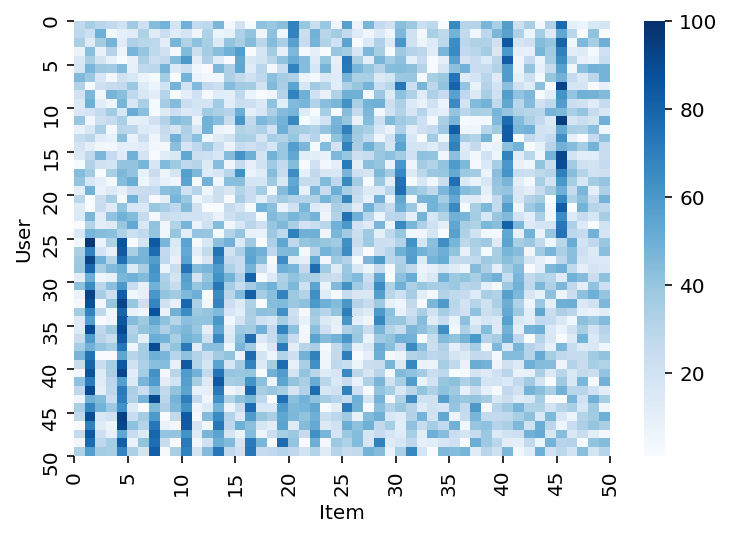

In [8]:
toy_data = load_toymat(users=50, items=50, random_state=0)
plot_mat(toy_data)

# Fitting a model

Fitting a model works similarily to libraries like `sklearn`. You just need to initialize a model object and call its `.fit` method. When working with _dense_ data, i.e. every user rated every item, we need initialize the model with a mask or value between 0-1 that indicates what proportion of the observed data should be treated as "missing." This allows us to simulate a situation in which we hadn't observed these ratings at all.  

Using `n_mask_items` we can masking out 25% of the ratings and retain 75%. Notice how some user-item combinations are now set to `NaN`.

In [3]:
model = NNMF_sgd(toy_data, n_mask_items=.25, random_state=0)

# Take a look the first 10 user x item predictions
model.masked_data.iloc[:10,:10]

Item,0,1,2,3,4,5,6,7,8,9
User,,,,,,,,,,
0,27.440675,35.759468,30.138169,NaN,21.182740,37.294706,NaN,44.588650,48.183138,19.172076
1,28.509839,21.930076,49.418692,5.102241,10.443838,13.065476,32.655416,NaN,23.315539,12.221280
2,33.890827,13.500399,36.759701,NaN,12.437657,33.807867,NaN,28.612595,11.154082,47.637451
3,7.472415,43.406303,NaN,30.777978,6.190999,NaN,40.365948,28.455037,20.359165,3.458350
4,15.589794,34.817174,NaN,8.980184,NaN,8.362482,33.969639,22.684842,26.828961,NaN
5,17.780637,NaN,38.266263,37.433181,NaN,9.171122,27.609623,NaN,48.096819,NaN
6,45.327775,38.702367,16.657258,4.055069,NaN,16.611707,NaN,2.671359,36.279718,0.571373
7,32.278512,NaN,21.520122,NaN,26.808875,NaN,13.879805,6.443028,NaN,NaN
8,NaN,46.464571,NaN,47.265077,NaN,27.708120,NaN,NaN,NaN,NaN


Now we can try to predict these missing ratings by fitting the model and plotting its predictions.  
The left matrix is the input data after masking. The middle is model predictions for the missing ratings +  the ratings we did observe. The right is a scatter plot model predictions for missing ratings vs the true values of the these ratings.  

For convenience the plot title contains the RMSE and correlation of the missing ratings (averaged across users to account for user-level clustering). RMSE is interpretable as the average misprediction on the same scale as the original ratings. In this case 1-100.


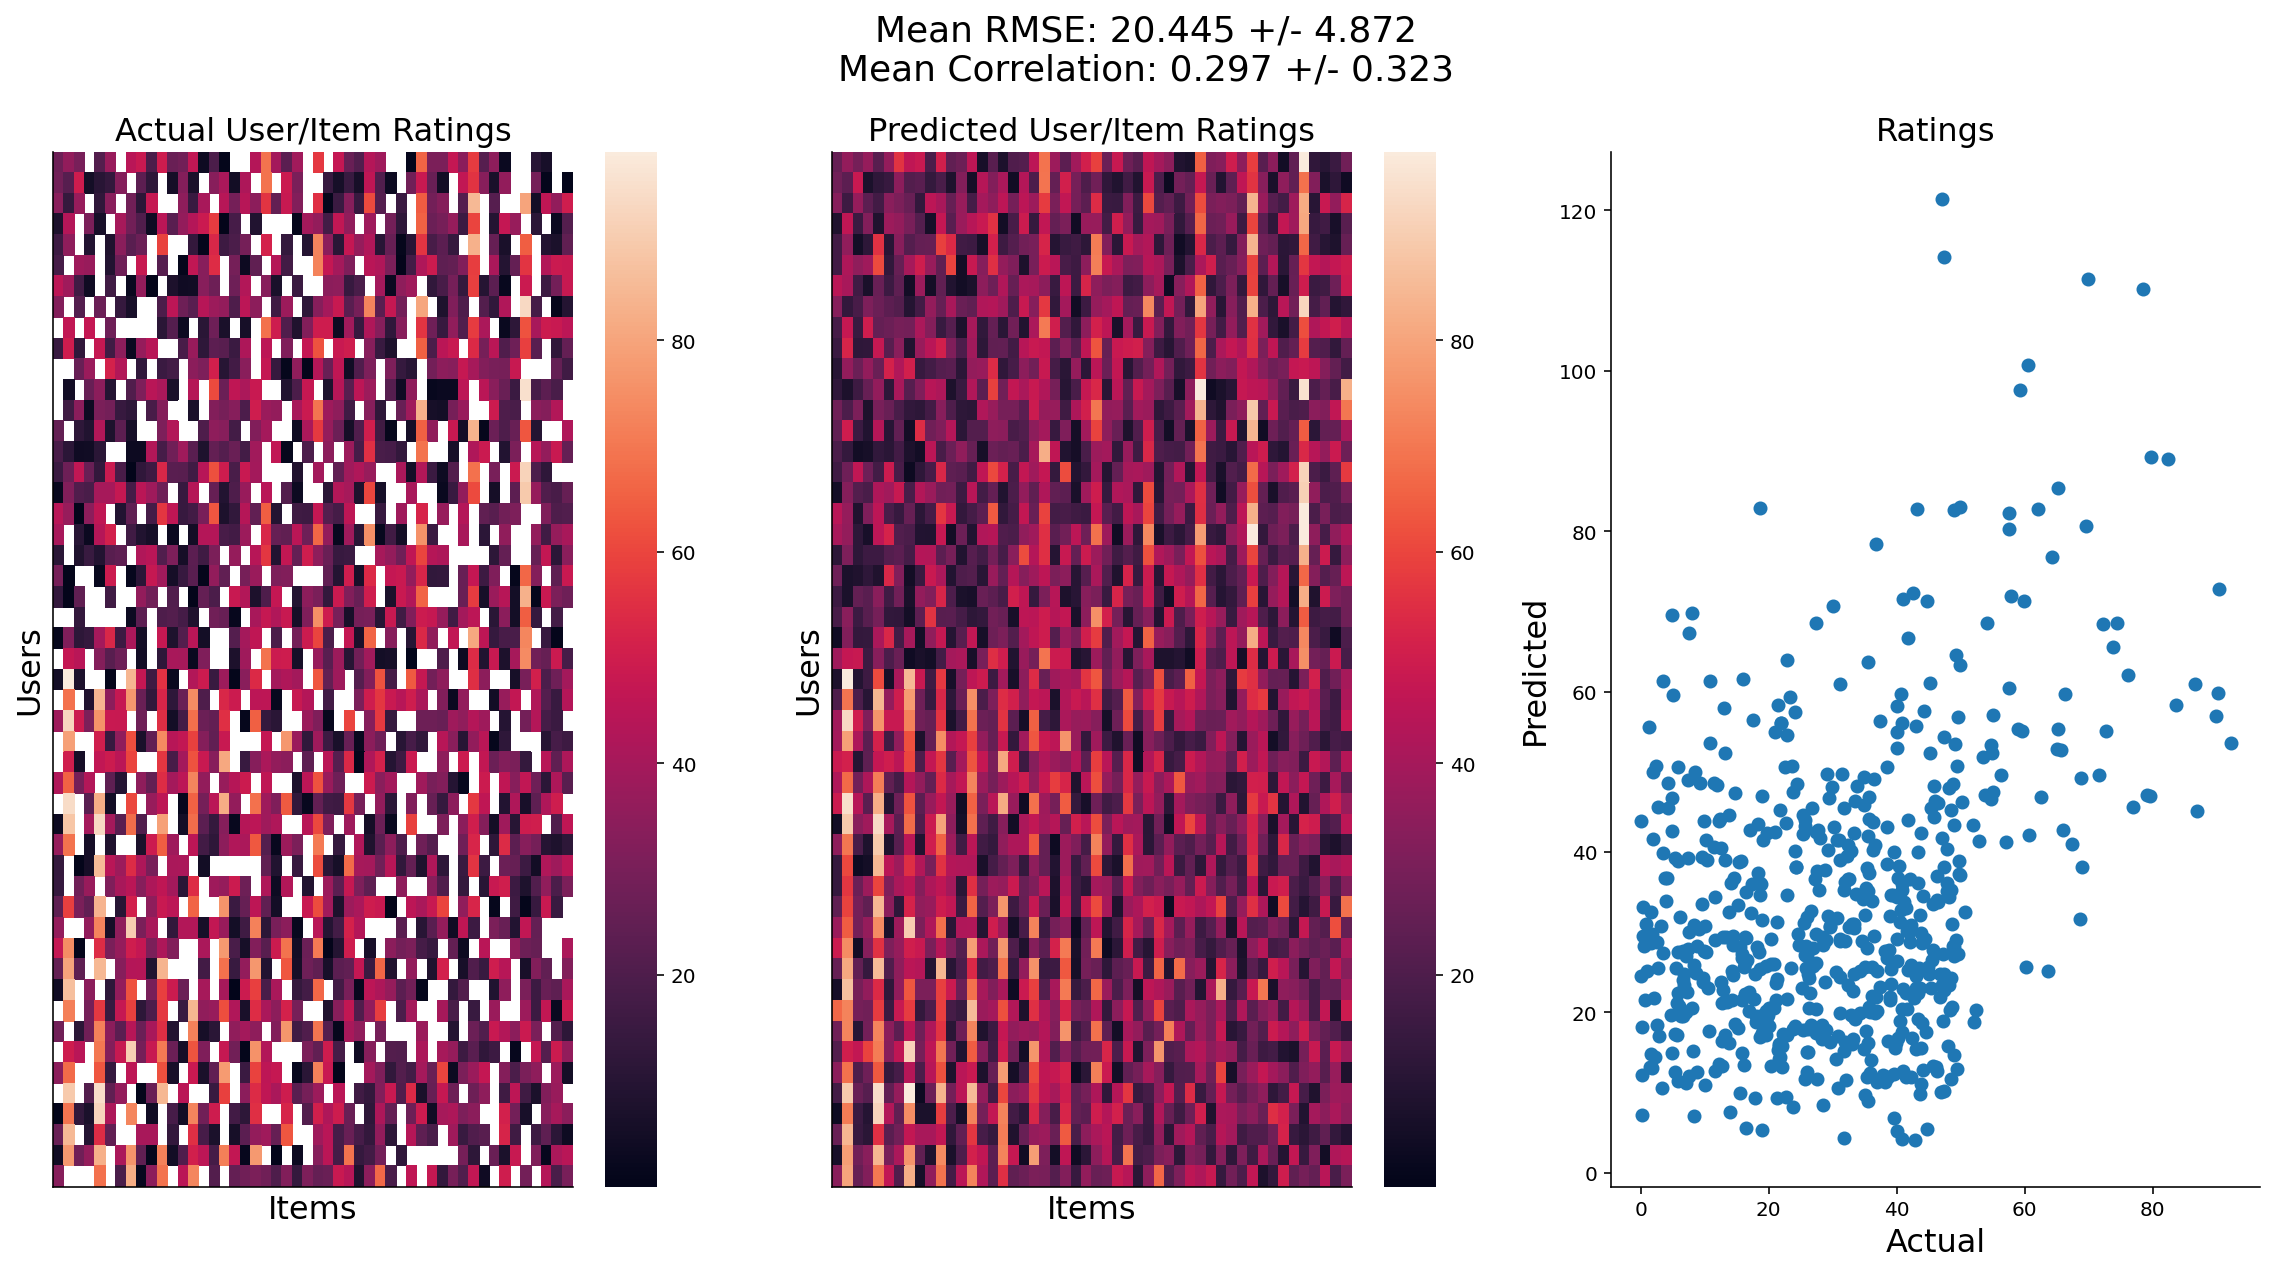

In [10]:
model.fit()
model.plot_predictions();

To retrieve the matrix containing the model predictions we can use the `.transform` method. Be default this will return a matrix containing ratings for values that were _observed_ and _predictions_ for values that were missing (i.e. masked out). To return predictions for the observed values as well, i.e. not passing forward these values, set `return_only_predictions=True`. 

Now the masked out ratings have been replaced with model predictions:

In [11]:
predictions = model.transform()
# Take a look the first 10 user x items after masking
predictions.iloc[:10,:10]

Item,0,1,2,3,4,5,6,7,8,9
User,,,,,,,,,,
0,27.440675,35.759468,30.138169,36.660519,21.182740,37.294706,56.100570,44.588650,48.183138,19.172076
1,28.509839,21.930076,49.418692,5.102241,10.443838,13.065476,32.655416,21.191779,23.315539,12.221280
2,33.890827,13.500399,36.759701,23.337345,12.437657,33.807867,30.578051,28.612595,11.154082,47.637451
3,7.472415,43.406303,15.179831,30.777978,6.190999,38.134221,40.365948,28.455037,20.359165,3.458350
4,15.589794,34.817174,5.257692,8.980184,55.577116,8.362482,33.969639,22.684842,26.828961,25.627142
5,17.780637,41.777774,38.266263,37.433181,61.015818,9.171122,27.609623,40.282928,48.096819,36.694523
6,45.327775,38.702367,16.657258,4.055069,26.051788,16.611707,23.999081,2.671359,36.279718,0.571373
7,32.278512,13.093412,21.520122,31.101120,26.808875,23.499822,13.879805,6.443028,17.163445,36.159055
8,18.240560,46.464571,14.868483,47.265077,25.477137,27.708120,29.443827,28.951392,41.470059,32.561340


For `NNMF` models it's easy to inspect and debug model training using the `.plot_learning` function. It's also possible to get more detail while fitting, by passing `verbose=True` to `.fit`.  
The plot title below also displays the final RMSE on the _observed_ ratings during training and indicates whether the model fit converged within the number of iterations.

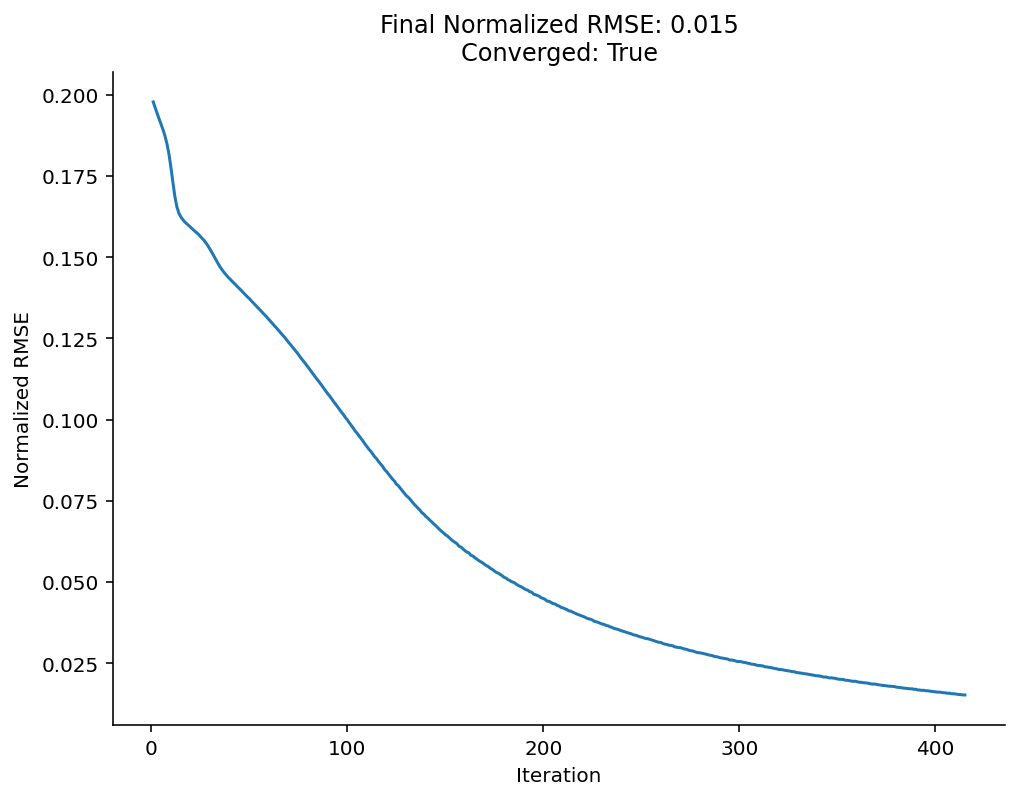

In [6]:
model.plot_learning();

# Scoring a model's predictions

Working with dense data affords us a grouth truth that can be used to asses the model's performance. We support a number of different metrics to do this (RMSE and correlation in the plots above are just two). To return a model's performance you can use the `.score` method. However, the `.summary` method maybe more convenient as it returns all supported metrics along with separate scoring for both the observed ratings (model training performance) and missing values (model testing performance)

Additionally, metrics are scored in two different ways. `user` metrics below score performance separately by each user first and then average these scores. This approach is more commong to the social science where observations are treated as "clustered" by user. `all` simply scores all ratings ignoring the fact that multiple ratings come from each user. This method is more common in machine-learning where overall model performance is of primary interest.

In [13]:
model.summary(verbose=True)

User performance results (not returned) are accessible using .user_results
Overall performance results (returned) are accesible using .overall_results


,algorithm,dataset,group,metric,score
0,NNMF_sgd,missing,all,correlation,0.360521
1,NNMF_sgd,missing,all,mae,16.760530
2,NNMF_sgd,missing,all,mse,441.263698
3,NNMF_sgd,missing,all,rmse,21.006278
4,NNMF_sgd,missing,user,correlation,0.297074
5,NNMF_sgd,missing,user,mae,16.760530
6,NNMF_sgd,missing,user,mse,441.263698
7,NNMF_sgd,missing,user,rmse,20.445180
8,NNMF_sgd,observed,all,correlation,0.995488
9,NNMF_sgd,observed,all,mae,1.519559


# Benchmarking a model's performance

The performance above is specific the the exact ratings we masked out. But how does the model perform _in general_ when 25% of the data is missing? 

While we could repeat the procedure above for different random masks of the same size, doing so by hand is a bit tedious. Fortunately, the `estimate_performance` function is designed exactly for this purpose. Just pass it a model class (not a model object), some data, and the amount of masking and it will repeatedly refit the model with new random masks and return the average performance across all iterations. This is functionally equivalent to randomized cross-validation, where the size of the training and testing splits are controlled via the `n_mask_items` argument. In the example below, masking 25% of the data is equivalent to 4-fold cross-validation where training is done using 3 folds and testing is performed on the left out fold.  

In [14]:
overall_results, user_results = estimate_performance(
    NNMF_sgd, toy_data, n_iter=10, n_mask_items=.25
)
overall_results

Data sparsity is 0.0%. Using random masking...


,algorithm,dataset,group,metric,mean,std
0,NNMF_sgd,missing,all,correlation,0.361321,0.039224
1,NNMF_sgd,missing,all,mae,17.722848,0.532381
2,NNMF_sgd,missing,all,mse,493.397942,34.549618
3,NNMF_sgd,missing,all,rmse,22.200547,0.770019
4,NNMF_sgd,missing,user,correlation,0.322631,0.038444
5,NNMF_sgd,missing,user,mae,17.722848,0.532381
6,NNMF_sgd,missing,user,mse,493.397942,34.549618
7,NNMF_sgd,missing,user,rmse,21.695961,0.672878


We can also see if predictive performance varied by user to identify some users that were particularly difficult to generate predictions for.

In [15]:
user_results.head()

,rmse_missing,mse_missing,mae_missing,correlation_missing
user,,,,
0,19.988851,408.599276,16.442676,0.306068
1,25.840342,748.642060,20.213965,0.192995
2,18.997861,375.325530,15.596407,0.482213
3,21.942705,499.427873,17.603425,0.271063
4,22.217112,506.409075,18.474751,0.358182


By default `estimate_performance` only returns performance `missing` data. To see performance on all subsets use `return_full_performance = True`. You can also use `return_agg=False` if you want to see performance for each iteration separately rather than the mean and std across all iterations.

# Summary

Those are the basics of working with models and dense data. The [next tutorial](/examples/sparse-data) illustrates the primary use case for the toolbox: working with sparse data.